In [ ]:
!wget https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz

In [ ]:
!tar xvfz YALE.tar.gz

In [13]:
from PIL import Image
# from imutils import paths
import glob2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
image_files = glob2.glob("YALE/centered/*")
names = []
states = []
images = []
for link in image_files:
  name = link.split("/")[-1].split(".")[0]
  state = link.split("/")[-1].split(".")[1]
  image = np.array(Image.open(link))
  names.append(name)
  states.append(state)
  images.append(image)

(231, 195)
(165, 231, 195)


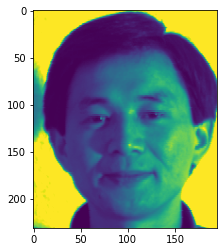

In [20]:
print(np.shape(images[1]))
print(np.shape(images))
plt.imshow(images[0])

In [21]:
print(len(images))
print(np.unique(names, return_counts = True))

165
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]))


In [23]:
import cv2

faceResizes = []
for face in images:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(165, 224, 224)

In [25]:
np.where(names=='subject01')

# names

(array([], dtype=int64),)

In [26]:
def _show_images(person):
      # Khởi tạo subplot với 2 dòng 5 cột.
  fg, ax = plt.subplots(2, 6, figsize=(20, 8))
  fg.suptitle('All images of one person')
  ids = np.flatnonzero(np.array(names) == person)
  total = 0
  for i in np.arange(2):
    for j in np.arange(6):
      try:
        image = cv2.cvtColor(images[ids[total]], cv2.COLOR_BGR2RGB)
        total+=1
        ax[i, j].imshow(image)
        ax[i, j].axis('off')
      except:
        ax[i, j].axis('off')
        next

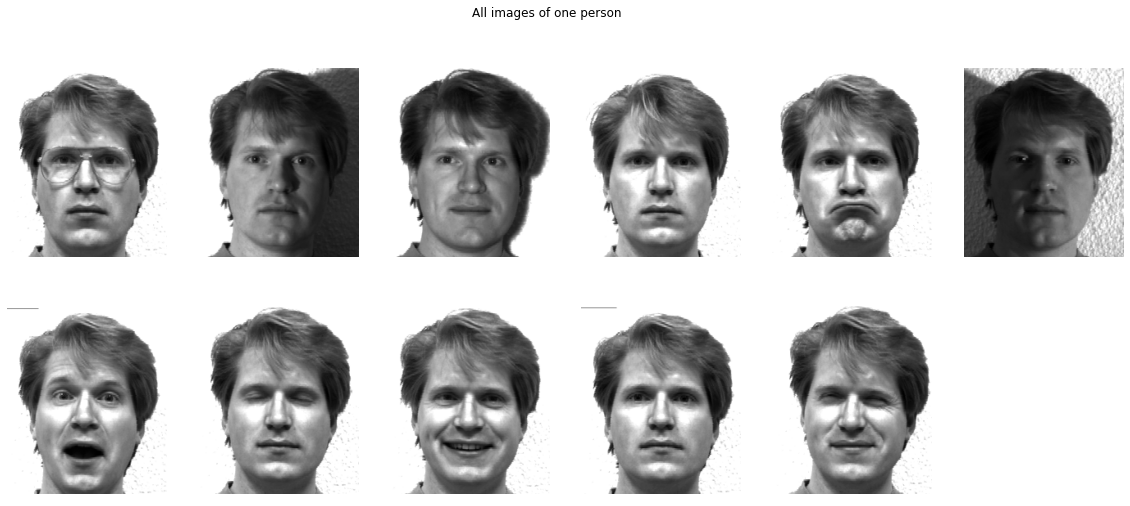

In [27]:
_show_images('subject01')

# 2.Huấn Luyện Model:

In [29]:
from sklearn.model_selection import train_test_split

In [30]:

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, names, np.array((X)), stratify = names, test_size = 1/11)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_test, return_counts=True))

(150, 224, 224)
(15, 224, 224)
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


In [32]:
import pickle

def _save_pickle(obj, link):
  with open(link, "wb") as f:
    pickle.dump(obj, f)

def _load_pickle(link):
  with open(link, "rb") as f:
    obj = pickle.load(f)
  return obj

_save_pickle(X, "YALE/X.pkl")
_save_pickle(names, "YALE/y.pkl")

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None, input_tensor=Input(shape=(224, 224, 1)))
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

2022-02-22 22:31:00.241015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 22:31:00.241103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-22 22:31:19.353935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 22:31:19.357201: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 22:31:19.358293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali-tuankiet): /proc/driver/nvidia/version does not exist
2022-02-22 22:31:21.112554: W tensorflow/core/framework/cpu_all

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [37]:
gen_train = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train, axis=-1), y_train)).repeat().shuffle(1024).batch(32)
gen_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

Train Model

In [38]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
42/50 [========================>.....] - ETA: 25:27 - loss: 0.8666

In [ ]:
model.save('face_yale.h5')